### Word2Vec

---



Word embedding is a type of word representation that enables words with similar meaning to have a similar representation, for example, "data" and "science", "daughter" and "girl".

Word2vec model is a distributed word representation method to capture similarities in both syntactic and semantic aspects between words using multiple dimensions. The main idea is to represent words as feature vectors. Each entry in vector stands for one hidden feature inside the word meaning. They can reveal semantic or syntactic dependencies. Word2vec actually leverages a neural network to discover word associations from a large text corpus.
One of its applications is movie recommendation engine - media services like Youtube and Netflix suggest similar kinds of videos / movies you watched earlier. While Collaborative Filtering can be one way of finding new movies shared by a group of people based on the past view behaviours (their common interest), it does not work well for new users.

Content-based filtering can take either / both the movies' information and the user information into account. It can also allow taking in information from user generated contexts related to the movies like film reviews and feedback. This potentially provides richer resources for forming features of the movies and evaluation of past users who might share the same interests.

Building a movie recommendation engine – How can we get there?

1. Dataset for movie recommender

Dataset Used: We make use of the IMDB 5000 Movie Dataset from Kaggle. It provides data containing 28 features of 5043 movies across 100 years in 66 countries. The dataset provide rich contents of movie information including plot keywords, genres, actor and director names and would be very helpful in our movie recommender implementation using Word2Vec.

In [1]:
# Explore the data
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv("movie_metadata.csv")
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


2. Data Processing:

We will demonstrate how we will process our movie metadata in our demo code below, which consists of the following steps:

Step 1.	Text cleansing
- We normalize our movie data by converting all characters to lower case and trimming spaces. We also separate the keywords provided in "genres" and "plot_keywords" to facilitate later processing. Lastly, we fill in the NaN values in some records.

Step 2.	Tokenization
- Tokenization here consists of two parts - the first part produces a list of keywords relate to each movie, and the second part appends additional information related to the movies: the original movie names, director name, names of main 3 actors and country, providing richer details for the model training. 

Step 3.	Stemming or Lemmatization 

- This step is for converting all different forms of a word, such as catch, caught, and catching to a common base form - in this case, catch.

Step 4.	Stop word removal
- It is for simply removing the words that appear frequently across all documents in the corpus. Removing stop words will have little impact in the overall contexts in the movie reocrds. In our case, we remove all the stop words from the tokens based on a standardized stop word list.

image title - Data Preprocessing Steps in Our Movie Recommender

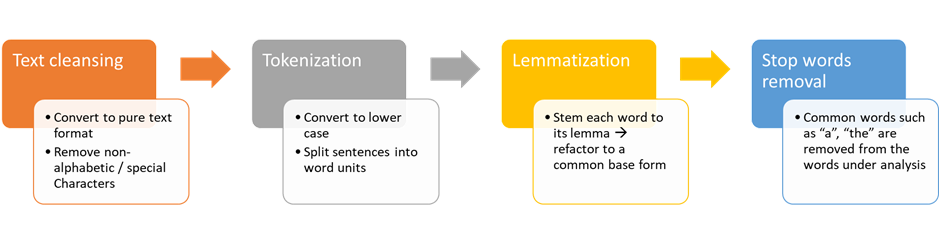

 

We will use Python and Word2vec model provided by gensim in our movie recommender system. NLTK - Natural Language Toolkit will be adapted for stop words and lemmatization processing in our data transformation steps.

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Our data pre-processing logics are illustrated in our demo code below:

In [3]:
# Convert text to lower-case and strip punctuation/symbols from words
def normalize_text(df):
    # Convert to lowercase
    new_df = df[['movie_title', 'plot_keywords','director_name','actor_1_name','actor_2_name','genres','title_year','actor_3_name', 'country', 'language']].copy()
    new_df['movie_title'] = new_df['movie_title'].str.lower().str.strip()
    new_df['plot_keywords'] = new_df['plot_keywords'].str.lower().str.strip()
    new_df['director_name'] = new_df['director_name'].str.lower().str.strip()
    new_df['actor_1_name'] = new_df['actor_1_name'].str.lower().str.strip()
    new_df['actor_2_name'] = new_df['actor_2_name'].str.lower().str.strip()
    new_df['actor_3_name'] = new_df['actor_3_name'].str.lower().str.strip()
    new_df['genres'] = new_df['genres'].str.lower().str.strip()
    new_df['country'] = new_df['country'].str.lower().str.strip()
    new_df['language'] = new_df['language'].str.lower().str.strip()
    
    # Replace "|" with " " for easier processing later
    new_df['genres'] = new_df['genres'].apply(lambda a: str(a).replace('|', ' '))
    new_df['plot_keywords'] = new_df['plot_keywords'].apply(lambda a: str(a).replace('|', ' '))

    # Fill NaN values with empty string
    new_df.fillna('', inplace=True)

    return new_df

# Tokenizer
def tokenize_text(df, cols):
    new_df = df.copy()
    new_df['tokens'] = new_df[cols].agg(','.join, axis=1)
    new_df['tokens'] = new_df['tokens'].str.split(r'\W+')

    # Make sure all empty strings are cleared
    new_df['tokens'] = new_df['tokens'].apply(lambda row: list(filter(lambda item: item, row)))
    return new_df

# Data Pre-processing Steps
# Step 1: Text Cleansing

cleaned_df = normalize_text(df)

# Step 2: Tokenization

# Step 2a - keywords (tags) tokenization
tokenized_df = tokenize_text(cleaned_df, ['movie_title', 'genres', 'plot_keywords'])

# Step 2b - append other features as tokens
tokenized_df['tokens'] = tokenized_df.apply(lambda row: [row['movie_title'], row['director_name'], row['actor_1_name'], row['actor_2_name'], row['actor_3_name'], row['country']] + row['tokens'], axis=1)

# Step 3: Lemmatization
def lemmatize_words(words):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in words]

tokenized_df['tokens'] = tokenized_df['tokens'].apply(lemmatize_words).apply(lambda row: list(filter(lambda item: item, row)))

# Step 4: Stop Words Removal
stop = nltk.corpus.stopwords.words('english')

tokenized_df['tokens'] = tokenized_df['tokens'].apply(lambda x: [word for word in x if word not in stop])

tokenized_df[['movie_title', 'tokens']].head()


,movie_title,tokens
0,avatar,"[avatar, james cameron, cch pounder, joel davi..."
1,pirates of the caribbean: at world's end,"[pirates of the caribbean: at world's end, gor..."
2,spectre,"[spectre, sam mendes, christoph waltz, rory ki..."
3,the dark knight rises,"[the dark knight rises, christopher nolan, tom..."
4,star wars: episode vii - the force awakens,"[star wars: episode vii - the force awakens, d..."


Just a quick glimpse at the processed movie record "Catch Me If You Can"

In [4]:
tokenized_df[tokenized_df['movie_title']=='catch me if you can']

,movie_title,plot_keywords,director_name,actor_1_name,actor_2_name,genres,title_year,actor_3_name,country,language,tokens
911,catch me if you can,attorney cat and mouse fbi pan am pilot,steven spielberg,leonardo dicaprio,tom hanks,biography crime drama,2002.0,jennifer garner,usa,english,"[catch me if you can, steven spielberg, leonar..."


To training Word2vec model, we adopt the following parameters below.

In [49]:
# Parameters of Word2vec model
num_features = 100  # Dimension of word vectors - it defines the number of words each token in the vocabulary is associated with
min_word_count = 1   # Words with occurance below the threshold will be ignored
num_workers = 4       # Number of threads to run in parallel
context = 5          # Context window size for each word
sg = 0 # 0 for CBOW, 1 for skipgram                                     

Training the model just involves one step initialization and assigning the dataset as below. For demo purpose, here we use all the data for training the model and use the model to provide movie recommendations.

In [66]:
from gensim.models import word2vec

# Building Word2Vec Model
dataset = [row for row in tokenized_df['tokens']]
print(dataset[911])
model = word2vec.Word2Vec(dataset, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)

# If the model is not going to be trained further, init_sims can be called 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

['catch me if you can', 'steven spielberg', 'leonardo dicaprio', 'tom hanks', 'jennifer garner', 'usa', 'catch', 'biography', 'crime', 'drama', 'attorney', 'cat', 'mouse', 'fbi', 'pan', 'pilot']


Output:

['catch me if you can', 'steven spielberg', 'leonardo dicaprio', 'tom hanks', 'jennifer garner', 'usa', 'catch', 'biography', 'crime', 'drama', 'attorney', 'cat', 'mouse', 'fbi', 'pan', 'pilot']

Our model has a vocabulary of 20727 unique words with vector size of 100 (defined as one of our model parameters). 

In [67]:
X = model[model.wv.vocab]
X.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(20727, 100)

Output:
(20727, 100)

Before making use of the model for movie suggestion, we can find out the top-N most similar words with the model with positive and negative tokens - positive words contribute positively towards the similarity, negative words negatively.

In [82]:
model.wv.most_similar(positive=['action'])

[('adventure', 0.9997739791870117),
 ('fantasy', 0.9997647404670715),
 ('thriller', 0.9995105266571045),
 ('family', 0.9995002150535583),
 ('horror', 0.9994605779647827),
 ('mystery', 0.999297022819519),
 ('creature', 0.9992091655731201),
 ('animation', 0.99915611743927),
 ('dragon', 0.9991492033004761),
 ('planet', 0.9990646243095398)]

Output:

[('adventure', 0.9997739791870117),
 ('fantasy', 0.9997647404670715),
 ('thriller', 0.9995105266571045),
 ('family', 0.9995002150535583),
 ('horror', 0.9994605779647827),
 ('mystery', 0.999297022819519),
 ('creature', 0.9992091655731201),
 ('animation', 0.99915611743927),
 ('dragon', 0.9991492033004761),
 ('planet', 0.9990646243095398)]

Next, let's find out the most recommended movies for 'Catch Me If You Can'!
We go ahead and implement our movie recommender as below.

In [69]:
person_list = list(tokenized_df['director_name'])+list(tokenized_df['actor_1_name'])+list(tokenized_df['actor_2_name'])+list(tokenized_df['actor_3_name'])

def similar_watch(v, n = 7):
     
    # extract most similar movies for the input vector
    ms = model.wv.similar_by_vector(v, topn= n+1)[1:]
     
    # extract name and similarity score of the similar movies
    new_ms = pd.DataFrame()
    for j in ms:
        if j[0] not in person_list:
            r = tokenized_df.loc[(tokenized_df['movie_title'].str.contains(j[0], case=False)) | \
                             (tokenized_df['plot_keywords'].str.contains(j[0], case=False)) | \
                             (tokenized_df['genres'].str.contains(j[0], case=False))]
            new_ms = pd.concat([new_ms, r], ignore_index = True, axis = 0)
    return new_ms.head(7)

results = similar_watch(model.wv['catch me if you can'])
results

,movie_title,plot_keywords,director_name,actor_1_name,actor_2_name,genres,title_year,actor_3_name,country,language,tokens
0,three burials,cemetery friend journey mexico promise,tommy lee jones,levon helm,dwight yoakam,adventure crime drama mystery western,2005.0,guillermo arriaga,france,english,"[three burials, tommy lee jones, levon helm, d..."
1,poultrygeist: night of the chicken dead,castration chicken fast food indian burial gro...,lloyd kaufman,john karyus,lloyd kaufman,comedy horror musical,2006.0,kate graham,usa,english,"[poultrygeist: night of the chicken dead, lloy..."
2,stargate sg-1,2000s 21st century alternate history message f...,,christopher judge,don s. davis,action adventure drama sci-fi,,gary jones,usa,english,"[stargate sg-1, christopher judge, don s. davi..."
3,star trek: first contact,21st century borg borg sphere captain sphere,jonathan frakes,levar burton,alfre woodard,action adventure drama sci-fi thriller,1996.0,jonathan frakes,usa,english,"[star trek: first contact, jonathan frakes, le..."
4,21 jump street,narcotics parody police remake undercover cop,phil lord,channing tatum,dax flame,action comedy crime,2012.0,rob riggle,usa,english,"[21 jump street, phil lord, channing tatum, da..."
5,21,based on true story blackjack card counting ga...,robert luketic,kevin spacey,jim sturgess,crime drama thriller,2008.0,josh gad,usa,english,"[21, robert luketic, kevin spacey, jim sturges..."
6,tank girl,2030s 21st century desert jet tank,rachel talalay,naomi watts,lori petty,action comedy sci-fi,1995.0,jeff kober,usa,english,"[tank girl, rachel talalay, naomi watts, lori ..."


We will also visualize the word vectors by squishing the using t-SNE and observe any emerging data patterns. t-SNE is one technique for dimension reduction for visualizing data in high dimensionality.

Reference code below - Credits to Charlene Chambliess - source adopted from: 

https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

In [70]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in [item for sublist in dataset for item in sublist] if word in model.wv.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in [item for sublist in dataset for item in sublist] if word in model.wv.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
avatar,-0.227552,-0.019240,-0.212131,-0.037217,0.005749,0.053704,0.096182,-0.016476,0.054478,0.089261,-0.133631,-0.020324,0.122712,-0.147933,-0.006078,-0.029775,-0.001567,-0.163318,-0.063162,0.017068,-0.085673,-0.119593,-0.052803,0.147496,0.001220,0.087354,0.079398,-0.027330,-0.071405,0.007482,0.102430,0.073325,0.030731,0.046734,-0.123924,0.047071,0.044396,0.003543,-0.025912,0.109799,...,-0.034118,-0.006741,-0.004487,-0.052940,0.134815,-0.039217,-0.116459,0.015191,0.001023,0.120180,0.010690,0.272433,-0.034651,-0.153284,-0.045128,0.021166,0.040489,0.033673,0.141960,0.058571,0.183043,-0.015856,0.181822,0.018824,-0.003653,0.017836,0.108440,0.174009,-0.004501,0.027434,0.118889,0.203147,-0.134013,0.106500,-0.081242,-0.034213,0.164532,-0.040061,0.164417,0.056603
james cameron,-0.174309,-0.007572,-0.241780,-0.040830,0.011594,0.035447,0.117104,0.022289,0.038715,0.063988,-0.172626,-0.046056,0.159670,-0.140174,0.008400,-0.045595,0.015766,-0.151247,-0.082159,0.018292,-0.062794,-0.128622,-0.089524,0.152705,0.004162,0.066058,0.055967,-0.004255,-0.120216,-0.020165,0.070057,0.046297,0.037172,0.010725,-0.168594,0.050274,0.049250,0.000731,-0.004193,0.139370,...,-0.044233,-0.017216,-0.006497,-0.071331,0.115892,-0.022045,-0.097466,-0.007018,0.024603,0.144258,-0.013369,0.259566,-0.047394,-0.132299,-0.071957,0.070312,-0.003251,0.016300,0.100978,0.032351,0.166578,-0.028007,0.191662,-0.036206,-0.027842,0.023458,0.079562,0.190409,0.003018,0.036773,0.101309,0.179555,-0.170306,0.164269,-0.108855,-0.014049,0.154642,-0.029669,0.139156,0.058709
cch pounder,-0.200480,-0.009920,-0.246177,-0.005241,-0.010525,0.054071,0.124593,0.033348,0.031592,0.047066,-0.175751,-0.021598,0.167295,-0.167918,0.001204,-0.046146,0.025388,-0.141147,-0.077265,0.009545,-0.039543,-0.104240,-0.087403,0.159121,0.005481,0.068117,0.067154,-0.027758,-0.104924,0.012890,0.067227,0.082506,0.040411,-0.001270,-0.146185,0.038380,0.024703,-0.019216,-0.013608,0.130249,...,-0.059460,0.007780,0.033788,-0.074240,0.146234,-0.045880,-0.072000,-0.001546,0.026721,0.117069,-0.014955,0.244802,-0.031634,-0.119989,-0.069145,0.064508,0.021008,0.022656,0.132305,0.067116,0.156311,-0.048808,0.165746,-0.027864,-0.022243,0.050679,0.073593,0.183816,-0.005044,0.048565,0.108538,0.191715,-0.143749,0.129075,-0.112852,-0.019421,0.170133,-0.036217,0.152776,0.022648


As calculating the neighbor embeddings is very costly, we will only work on the top 400 rows to reduce the processing time incurred as an example of illustration.

In [ ]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
df
tsne_df = tsne.fit_transform(df[:400])

Finally, here comes the visualization showing projected word vectors -

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


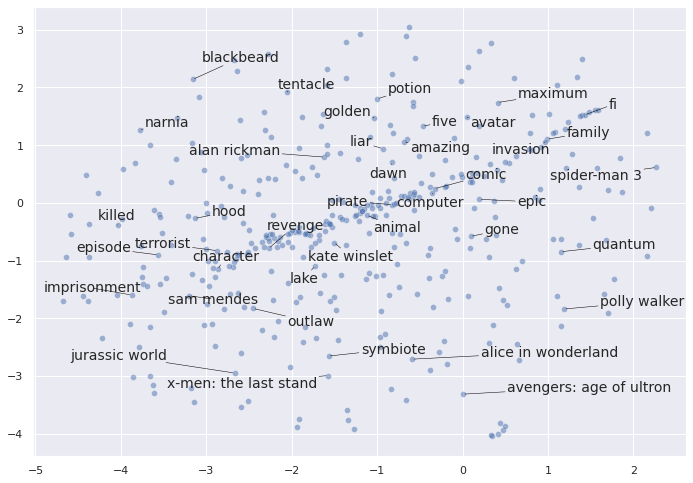

In [73]:
# Import adjustText
from adjustText import adjust_text
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

That's it! While there is much room for future work (like tuning parameters or further fine tuning on the fields to be used for generating the tokens), this serves a very good demonstration on how Word2vec can be leveraged in real business applications.